In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
spec_dir = '../data/train_data/spec/'
with_call = '../data/train_data/spec/1'
without_call = '../data/train_data/spec/0'

paths_with_call = [join(with_call, f) for f in listdir(with_call) if isfile(join(with_call, f))]
paths_without_call = [join(without_call, f) for f in listdir(without_call) if isfile(join(without_call, f))]

- (b) View Batch

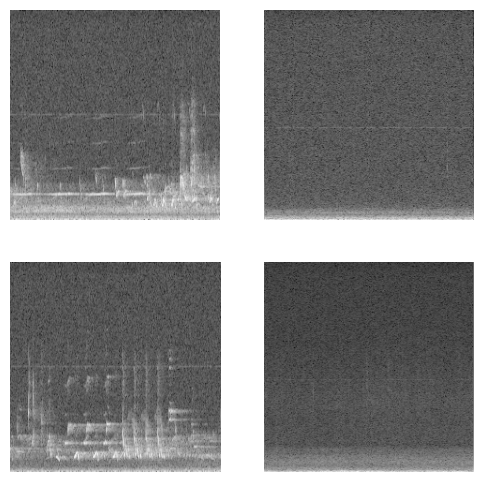

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_with_call[np.random.randint(len(paths_with_call))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_without_call[np.random.randint(len(paths_without_call))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_with_call[np.random.randint(len(paths_with_call))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_without_call[np.random.randint(len(paths_without_call))]));

Define Batch size

In [5]:
batch_size = 16

## B - <a name="generateurs"></a> Data Generators



In [6]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

"""test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   batch_size = batch_size)"""


Found 3307 images belonging to 2 classes.
Found 826 images belonging to 2 classes.


"test_data  = test_data_generator.flow_from_directory(directory = spec_dir,\n                                                   target_size = (224, 224),\n                                                   class_mode = 'binary',\n                                                   batch_size = batch_size)"

In [9]:
import pandas as pd
import os

# Get all file paths and their corresponding labels
filepaths = [os.path.join(training_data.directory, fname) for fname in training_data.filenames]
labels = training_data.classes

# Convert to DataFrame
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

Oversample 

In [10]:
from collections import Counter

class_counts = Counter(training_data.classes)
print("Class Distribution:", class_counts)

max_samples = max(Counter(labels).values())  # Find max class count
df_oversampled = df.groupby('label', group_keys=False).apply(lambda x: x.sample(max_samples, replace=True))
df_oversampled.label = df_oversampled.label.astype(str)

print(df_oversampled['label'].value_counts())  # Check new distribution

Class Distribution: Counter({0: 2660, 1: 647})
0    2660
1    2660
Name: label, dtype: int64


In [11]:
training_data_os = data_generator.flow_from_dataframe(
    dataframe=df_oversampled,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=True
)

Found 5320 validated image filenames belonging to 2 classes.


# II - <a name="classif"></a> Classification

- (a) Importer le modèle 

- (b) Instancier un réseau de neurones (appelé ```model```), 

- (c) Compiler le modèle avec une métrique appropriée.

- (d) Entraîner le modèle avec les paramètres de votre choix. On pourra également définir des callbacks.

- (e) Evaluer le modèle sur les données de test avec la méthode ```evaluate```.

In [12]:
# Modèle VGG16
#base_model = VGG16(weights='imagenet', include_top=False)
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches du VGG16
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\dgnhk\AppData\Local\Temp\ipykernel_16032\2462421750.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)


In [13]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 4,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience=3,
                                         factor=0.5,
                                         verbose=2,
                                         mode='min',
                                         min_lr = 1e-10)

In [14]:
optimizer = Adam(learning_rate=0.0001) 

In [15]:
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
history = model.fit(training_data, validation_data=validation_data, epochs=25, callbacks=[early_stopping,lr_plateau])

Epoch 1/25


c:\Users\dgnhk\anaconda3\envs\yevhenii\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


207/207 ━━━━━━━━━━━━━━━━━━━━ 68s 308ms/step - accuracy: 0.7427 - loss: 0.5428 - val_accuracy: 0.8136 - val_loss: 0.3489 - learning_rate: 1.0000e-04
Epoch 2/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.8928 - loss: 0.2735 - val_accuracy: 1.0000 - val_loss: 0.0903 - learning_rate: 1.0000e-04
Epoch 3/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 26s 124ms/step - accuracy: 0.9822 - loss: 0.0885 - val_accuracy: 1.0000 - val_loss: 0.0282 - learning_rate: 1.0000e-04
Epoch 4/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.9904 - loss: 0.0460 - val_accuracy: 1.0000 - val_loss: 0.0146 - learning_rate: 1.0000e-04
Epoch 5/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - accuracy: 0.9941 - loss: 0.0313 - val_accuracy: 1.0000 - val_loss: 0.0086 - learning_rate: 1.0000e-04
Epoch 6/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.9960 - loss: 0.0177 - val_accuracy: 1.0000 - val_loss: 0.0071 - learning_rate: 1.0000e-04
Epoch 7/25
207/207 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step - 

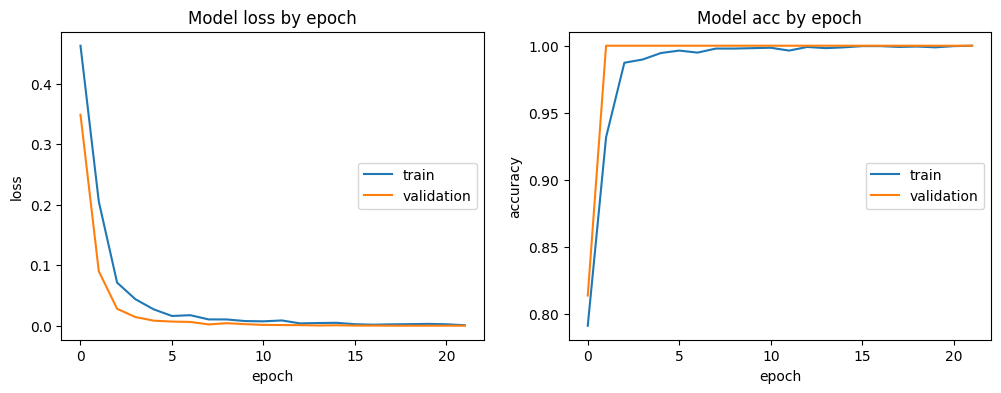

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [18]:
#model.save('../models/my_model_epochs20.h5')